Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model

Load dataset and prepare df

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "period"
target_column = "value"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df = df.groupby(date_column).sum().reset_index()
df.set_index(date_column, inplace=True)
df = df.dropna()
dates = df.index.values

Train test split

In [3]:
data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

Parameter tuning for order

In [4]:
stepwise_fit = auto_arima(df[target_column], trace=True, suppress_warnings=True)
best_order = stepwise_fit.order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=238296.571, Time=5.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=243622.092, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=240106.220, Time=1.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=241541.411, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=243620.093, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=239070.291, Time=2.54 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=239273.713, Time=3.00 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=238283.450, Time=13.85 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=237795.001, Time=9.73 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=239269.189, Time=2.54 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=237488.771, Time=9.65 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=238989.142, Time=3.33 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=237434.967, Time=11.03 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=238647.285, Time=4.16 sec
 AR

In [5]:
print(best_order)

(5, 1, 4)


Create Model

In [6]:
model = ARIMA(train[target_column], order=best_order)
model = model.fit()
model.summary()

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                10320
Model:                 ARIMA(5, 1, 4)   Log Likelihood             -106978.659
Date:                Tue, 30 Apr 2024   AIC                         213977.319
Time:                        14:29:34   BIC                         214049.736
Sample:                    01-02-2023   HQIC                        214001.794
                         - 03-07-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0866      0.124      0.701      0.483      -0.156       0.329
ar.L2          1.0883      0.103     10.535      0.000       0.886       1.291
ar.L3          0.4010      0.124      3.231      0.001       0.158       0.644
ar.L4         -0.7290      0.073    -10.002      0.000      -0.872      -0.586
ar.L5         -0.1443      0.025     -5.884      0.000      -0.192      -0.096
ma.L1          0.1007      0.124      0.812      0.417      -0.142       0.344
ma.L2         -0.8639      0.084    -10.339      0.000      -1.028      -0.700
ma.L3         -0.5130      0.110     -4.667      0.000      -0.728      -0.298
ma.L4          0.3961      0.050      7.977      0.000       0.299       0.493
sigma2       6.05e+07   5.33e-08   1.14e+15      0.000    6.05e+07    6.05e+07
===================================================================================
Ljung-Box (L1) (Q):                  31.48   Jarque-Bera (JB):           2019964.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                             1.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        71.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.02e+29. Standard errors may be unstable.
"""

In [5]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, typ="levels")

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [6]:
non_zero = []
 
for i in pred:
    removed_initial_one = i-1
    if removed_initial_one == 0:
        non_zero.append(removed_initial_one+sys.float_info.min)
    else:
        non_zero.append(removed_initial_one)

Plot the result

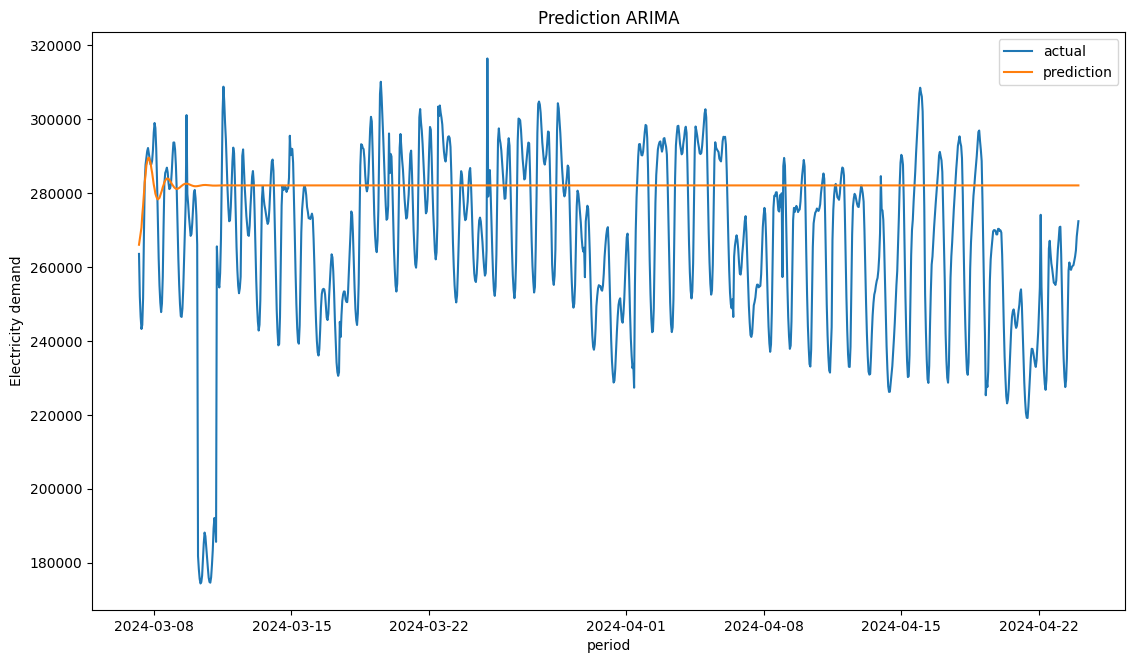

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(pd.to_datetime(dates[int(data_length*train_split):]), (test[target_column]-1).values, label="actual")
ax.plot(pd.to_datetime(dates[int(data_length*train_split):]), non_zero, label="prediction")
ax.set_title("Prediction ARIMA")
ax.set_ylabel("Electricity demand")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

RMSE of the result

In [10]:
print_evaluation_metrics(non_zero, test[target_column]-1, train[target_column]-1)

Evaluation Metrics:
MSE: 770978221.06
RMSE: 27766.49
MAE: 20614.23
MAPE: 8.44
SMAPE: 7.80
MASE: 2.81


In [11]:
store_model(model, "arima")